# Feature Engineering con PyTS (HAR)

En este notebook se construirá conjuntos de *features* basados en transformaciones de series temporales usando **PyTS** sobre el dataset HAR (ventanas de 2.56 s, 128 pasos, 9 canales).  

**Salidas:**  
- **Resumen de Características** (`../reports/tables/pyts_feature_summary.csv`): Un archivo de metadatos que documenta la configuración y dimensiones de cada conjunto de características generado, asegurando la trazabilidad. 
- **Set de Features PAA** (`../artifacts/pyts_features_PAA.npz`): Un archivo comprimido con características basadas en Piecewise Aggregate Approximation, que capturan la forma global de las series de tiempo.

- **Set de Features BoP** (`../artifacts/pyts_features_BOP.npz`): Un archivo con características simbólicas basadas en Bag-of-Patterns, diseñadas para modelar la distribución de patrones locales y repetitivos.

- **Set de Features de Imagen** (`../artifacts/pyts_features_GAF_pooled.npz`): Un archivo opcional con características extraídas de la representación de las series como imágenes (Gramian Angular Fields), capturando su textura y dinámica 2D.

## 1. Carga y Normalización de Datos

En este primer paso, cargamos las series de tiempo del archivo `har_processed.npz`, obteniendo `X_train` con dimensiones de muestras, pasos de tiempo y canales, junto con las etiquetas `y_train`. Posteriormente, aplicamos **normalización Z-score** de forma independiente para cada uno de los 9 canales.

Este preprocesamiento es fundamental por dos razones: primero, garantiza que las señales de todos los sensores (acelerómetros y giroscopios) se encuentren en una escala común con media 0 y desviación estándar 1, evitando que los canales con magnitudes mayores dominen artificialmente el análisis. Segundo, muchas técnicas de análisis de series de tiempo, incluyendo PAA y SAX que se utilizarán posteriormente, son sensibles a la escala de los datos, por lo que la normalización asegura su funcionamiento estable y efectivo.

In [6]:
# ===============================
# 1. Carga de datos desde el caché
# ===============================
import numpy as np
import pandas as pd

# Ruta del archivo procesado
har_processed_path = "../data/har_processed.npz"

# Cargar
data = np.load(har_processed_path, allow_pickle=True)
X_train = data["X_train"]       # (n, 128, 9)
y_train = data["y_train"]       # (n,)
channel_names = data["channel_names"]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Canales:", channel_names)

# ===============================
# 2. Normalización Z-score por canal
# ===============================
# Forma de X_train: (n_muestras, n_pasos, n_canales)
n, T, C = X_train.shape

# Inicializamos array normalizado
X_norm = np.zeros_like(X_train, dtype=np.float32)

# Normalización independiente por canal
for c in range(C):
    mean_c = X_train[:, :, c].mean()
    std_c  = X_train[:, :, c].std()
    X_norm[:, :, c] = (X_train[:, :, c] - mean_c) / std_c
    print(f"Canal {channel_names[c]}: mean={mean_c:.3f}, std={std_c:.3f}")

# Reemplazamos X_train por versión normalizada
X_train = X_norm

# ===============================
# 3. Verificación de normalización
# ===============================
# Calculamos media y std por canal en el dataset normalizado
stats = []
for c in range(C):
    mean_c = X_train[:, :, c].mean()
    std_c  = X_train[:, :, c].std()
    stats.append([channel_names[c], round(mean_c, 3), round(std_c, 3)])

df_stats = pd.DataFrame(stats, columns=["Canal", "Media (≈0)", "STD (≈1)"])
display(df_stats)

X_train shape: (7352, 128, 9)
y_train shape: (7352,)
Canales: ['body_acc_x' 'body_acc_y' 'body_acc_z' 'body_gyro_x' 'body_gyro_y'
 'body_gyro_z' 'total_acc_x' 'total_acc_y' 'total_acc_z']
Canal body_acc_x: mean=-0.001, std=0.195
Canal body_acc_y: mean=-0.000, std=0.122
Canal body_acc_z: mean=-0.000, std=0.107
Canal body_gyro_x: mean=0.001, std=0.407
Canal body_gyro_y: mean=-0.001, std=0.382
Canal body_gyro_z: mean=0.000, std=0.256
Canal total_acc_x: mean=0.805, std=0.414
Canal total_acc_y: mean=0.029, std=0.391
Canal total_acc_z: mean=0.086, std=0.358


,Canal,Media (≈0),STD (≈1)
0,body_acc_x,0.0,1.0
1,body_acc_y,-0.0,1.0
2,body_acc_z,-0.0,1.0
3,body_gyro_x,0.0,1.0
4,body_gyro_y,0.0,1.0
5,body_gyro_z,0.0,1.0
6,total_acc_x,0.0,1.0
7,total_acc_y,0.0,1.0
8,total_acc_z,-0.0,1.0


## 2. Diseño de Estrategias de Características con `pyts`

Para representar las series de tiempo, se diseñaron tres estrategias complementarias que capturan diferentes aspectos de las señales de movimiento:

**Estrategia 1: Resumen Global con PAA (Piecewise Aggregate Approximation)**

PAA divide la secuencia de 128 puntos en segmentos más pequeños y calcula el promedio de cada uno. Esto captura la forma general de la señal: actividades dinámicas como caminar muestran patrones ondulatorios, mientras que actividades estáticas como sentarse son casi planas. Se genera un vector concatenado de características para los 9 canales.

**Estrategia 2: Patrones Locales con Bag-of-Patterns (BoP)**

BoP discretiza la señal en símbolos mediante SAX y cuenta la frecuencia de patrones recurrentes. Esto permite distinguir micro-patrones entre actividades similares: aunque caminar y subir escaleras son periódicas, la forma exacta de cada paso difiere. Se genera un histograma de frecuencias por canal que se concatena.

**Estrategia 3: Dinámica Visual con Imágenes (GAF o RP)**

Esta técnica convierte las series temporales en imágenes bidimensionales que revelan patrones de autocorrelación y dinámica no lineal. Se aplica solo a los canales más informativos (acelerómetros del cuerpo) y se resume mediante pooling para obtener vectores compactos que capturan la textura temporal de la señal.

In [7]:
# ============================================================
# HAR -> Normaliza -> PAA (denso pequeño) + BoP (SPARSE) + GAF (compacto)
# ============================================================
import os, gc, inspect
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.sparse import issparse

# ----------------------- Config rápida -----------------------
DATA_PATH = "../data/har_processed.npz"
CAP = 500          # procesa sólo primeras N muestras. Pon None para todo el dataset
BOP_WINDOW = 16
BOP_WORD   = 6     # más chico = menos vocabulario
BOP_BINS   = 5     # 4–6 razonable
GAF_SIZE   = 32    # más chico que 64 para bajar RAM
POOL_H     = 4
POOL_W     = 4

# ----------------------- Carga / Normaliza -------------------
def ensure_data(path=DATA_PATH):
    if not os.path.exists(path):
        raise FileNotFoundError(f"No se encontró: {path}")
    data = np.load(path, allow_pickle=True)
    X = data["X_train"]      # (n, T, C)
    y = data["y_train"]
    ch = data.get("channel_names", None)
    return X, y, ch

X_train, y_train, channel_names = ensure_data()
print("X_train:", X_train.shape, "| y_train:", y_train.shape)

# Normalización z-score por canal (robusta)
n, T, C = X_train.shape
Xn = np.zeros_like(X_train, dtype=np.float32)
for c in range(C):
    mu = float(X_train[:, :, c].mean())
    sd = float(X_train[:, :, c].std())
    if not np.isfinite(sd) or sd == 0: sd = 1.0
    Xn[:, :, c] = (X_train[:, :, c] - mu) / sd
X_train = Xn
del Xn; gc.collect()

# CAP de muestras (para evitar OOM durante pruebas)
if CAP is not None and CAP < X_train.shape[0]:
    X_run = X_train[:CAP]
    y_run = y_train[:CAP]
else:
    X_run = X_train
    y_run = y_train
print("Usando:", X_run.shape, "(CAP =", CAP, ")")

# ----------------------- Utils -------------------------------
def _supports_param(cls, name):
    return name in inspect.signature(cls.__init__).parameters

def check_matrix(X, name):
    if issparse(X):
        print(f"{name}: SPARSE shape={X.shape}, nnz={X.nnz}, dtype={X.dtype}")
        if X.nnz > 0 and not np.isfinite(X.data).all():
            raise ValueError(f"{name} contiene NaN/Inf en .data")
    else:
        if not isinstance(X, np.ndarray): 
            raise TypeError(f"{name} no es np.ndarray")
        if not np.isfinite(X).all():
            raise ValueError(f"{name} contiene NaN/Inf")
        print(f"{name}: shape={X.shape}, dtype={X.dtype}")

# ----------------------- PAA ---------------------------------
def features_paa(X, n_segments=32, pad_mode='edge'):
    from pyts.approximation import PiecewiseAggregateApproximation as _PAA
    n, T, C = X.shape
    if _supports_param(_PAA, 'n_segments'):
        paa = _PAA(n_segments=n_segments)  # API moderna
        feats = [paa.transform(X[:, :, c]) for c in range(C)]
    else:
        # API antigua: requiere window_size entero; paddings si no divide
        window_size = T // n_segments + (1 if T % n_segments else 0)
        T_need = window_size * n_segments
        if T_need != T:
            X = np.pad(X, ((0,0),(0, T_need - T),(0,0)), mode=pad_mode)
        paa = _PAA(window_size=window_size)
        feats = [paa.transform(X[:, :, c]) for c in range(C)]
    return np.concatenate(feats, axis=1).astype(np.float32, copy=False)

# ----------------------- BoP (SPARSE) ------------------------
def features_bop_sparse(
    X,
    window_size=BOP_WINDOW,
    word_size=BOP_WORD,
    n_bins=BOP_BINS,
    numerosity_reduction=True,
    sparse_output=True,
    strategy='normal'
):
    try:
        from pyts.transformation import BagOfPatterns as _BoX
    except ImportError:
        from pyts.transformation import BagOfWords as _BoX

    def supports(k): return k in inspect.signature(_BoX.__init__).parameters
    kwargs_all = dict(
        window_size=window_size, word_size=word_size, n_bins=n_bins,
        numerosity_reduction=numerosity_reduction, sparse=sparse_output,
        strategy=strategy
    )
    kwargs = {k:v for k,v in kwargs_all.items() if supports(k)}

    n, T, C = X.shape
    bop = _BoX(**kwargs)
    mats = []
    for c in range(C):
        H = bop.fit_transform(X[:, :, c])     # denso o disperso
        if not issparse(H):
            H = sparse.csr_matrix(H)
        mats.append(H)
        del H; gc.collect()
    X_bop = sparse.hstack(mats, format='csr')
    return X_bop

# ----------------------- GAF + pooling -----------------------
from pyts.image import GramianAngularField

def block_pool_2d(images, ph=POOL_H, pw=POOL_W):
    n, H, W = images.shape
    assert H % ph == 0 and W % pw == 0, f"Imagen {H}x{W} no múltiplo de {ph}x{pw}"
    hb, wb = H // ph, W // pw
    return images.reshape(n, hb, ph, wb, pw).mean(axis=(2,4))

def features_gaf_pooled(X, channel_indices, image_size=GAF_SIZE, method='summation'):
    n, T, C = X.shape
    ch = [int(ci) for ci in channel_indices if 0 <= int(ci) < C]
    if not ch: raise ValueError(f"channel_indices fuera de rango para C={C}")
    if image_size % POOL_H or image_size % POOL_W:
        raise ValueError("image_size debe ser múltiplo de POOL_H/POOL_W")

    gaf = GramianAngularField(image_size=image_size, method=method)
    feats = []
    for c in ch:
        imgs = gaf.fit_transform(X[:, :, c])        # (n, H, W)
        pooled = block_pool_2d(imgs, POOL_H, POOL_W)
        feats.append(pooled.reshape(n, -1))
        del imgs, pooled; gc.collect()
    return np.concatenate(feats, axis=1).astype(np.float32, copy=False)

# ----------------------- Selección de canales ----------------
if channel_names is not None:
    channel_names = [str(x) for x in channel_names]
    # intenta 3 acelerómetros "body_acc_*"; si no existen, usa 0,1,2
    wanted = ["body_acc_x","body_acc_y","body_acc_z"]
    idx = [channel_names.index(w) for w in wanted if w in channel_names]
    if len(idx) < 3:
        idx = [0,1,2][:min(3, X_run.shape[2])]
else:
    idx = [0,1,2][:min(3, X_run.shape[2])]

# ----------------------- Ejecución segura --------------------
print("\n[1/3] PAA...")
X_PAA = features_paa(X_run, n_segments=32)
check_matrix(X_PAA, "X_PAA")

print("\n[2/3] BoP (sparse)...")
X_BOP = features_bop_sparse(X_run)
check_matrix(X_BOP, "X_BOP")

print("\n[3/3] GAF + pooling...")
X_IMG = features_gaf_pooled(X_run, channel_indices=idx, image_size=GAF_SIZE, method='summation')
check_matrix(X_IMG, "X_IMG")

gc.collect()

# ----------------------- Resumen -----------------------------
print("\n===== RESUMEN =====")
print(f"PAA features: {X_PAA.shape[1]} (dense)")
print(f"BoP features: {X_BOP.shape[1]} (SPARSE, nnz={X_BOP.nnz})")
print(f"GAF features: {X_IMG.shape[1]} (dense, compact {GAF_SIZE} w/ pool {POOL_H}x{POOL_W})")

# Muestra estadísticas post-normalización
stats = []
for c in range(C):
    mu = float(X_train[:, :, c].mean())
    sd = float(X_train[:, :, c].std())
    stats.append([channel_names[c] if channel_names is not None else f"ch{c}", mu, sd])
df_stats = pd.DataFrame(stats, columns=["Canal", "Media", "STD"])
try:
    from IPython.display import display
    display(df_stats)
except Exception:
    print(df_stats)


X_train: (7352, 128, 9) | y_train: (7352,)
Usando: (500, 128, 9) (CAP = 500 )

[1/3] PAA...
X_PAA: shape=(500, 288), dtype=float32

[2/3] BoP (sparse)...
X_BOP: SPARSE shape=(500, 43532), nnz=464584, dtype=int64

[3/3] GAF + pooling...
X_IMG: shape=(500, 192), dtype=float32

===== RESUMEN =====
PAA features: 288 (dense)
BoP features: 43532 (SPARSE, nnz=464584)
GAF features: 192 (dense, compact 32 w/ pool 4x4)


,Canal,Media,STD
0,body_acc_x,3.040226e-10,1.0
1,body_acc_y,-1.459309e-10,1.0
2,body_acc_z,-1.135018e-10,1.0
3,body_gyro_x,1.556596e-09,1.0
4,body_gyro_y,5.026507e-10,1.0
5,body_gyro_z,2.432181e-11,1.0
6,total_acc_x,2.594326e-09,1.0
7,total_acc_y,1.816028e-09,1.0
8,total_acc_z,-2.257064e-08,1.0


## 3. Selección y Justificación de Hiperparámetros

La efectividad de las transformaciones de `pyts` depende de sus hiperparámetros. Los valores seleccionados equilibran capacidad representativa y simplicidad del modelo.

**Para PAA:**

Se utiliza `n_segments = 32`, reduciendo cada señal de 128 a 32 puntos mediante promediado. Esto suaviza el ruido y preserva la forma estructural, generando 288 características totales (9 canales × 32).

**Para Bag-of-Patterns:**

Se configuran `window_size = 16` para capturar micro-movimientos de aproximadamente 0.32 segundos, `word_size = 8` para equilibrar descripción y complejidad en la representación SAX, y `n_bins = 6` para discretizar la señal con granularidad adecuada sin excesiva sensibilidad al ruido.

**Para Imágenes (GAF o RP):**

Se genera `image_size = 64` con pooling a `8x8`, creando una huella digital de 64 características por canal. Se aplica solo a los acelerómetros corporales `body_acc_x`, `body_acc_y` y `body_acc_z` por contener la mayor información discriminativa, generando 192 características totales (3 canales × 64).

In [8]:
# =========================================
# Paso 3 — Hiperparámetros y justificación
# =========================================

# --- Metadatos conocidos del HAR ---
T = 128        # pasos por ventana
C = 9          # canales totales (body_acc, body_gyro, total_acc)
CHANNEL_KEYS = [
    "body_acc_x","body_acc_y","body_acc_z",
    "body_gyro_x","body_gyro_y","body_gyro_z",
    "total_acc_x","total_acc_y","total_acc_z"
]

# ---------------------------
# F1) PAA — configuración base
# ---------------------------
PAA_CFG = {
    "n_segments": 32,               # base recomendada (128/32=4 puntos por segmento)
    "sensibilidad": [16, 32, 64]    # alternativas: 16 (más suave), 64 (más detalle)
}
# Checks y features esperados
assert T % PAA_CFG["n_segments"] == 0, "Para PAA fija, T debe ser múltiplo de n_segments"
paa_feats = C * PAA_CFG["n_segments"]   # 9 * 32 = 288

# ---------------------------------------
# F2) Bag-of-Patterns (SAX) — config base
# (ajustado por alta dimensionalidad observada)
# ---------------------------------------
BOP_CFG = {
    "window_size": 16,     # patrón local ~ 'medio paso'
    "word_size": 6,        # más compacto que 8 para reducir vocabulario
    "n_bins": 5,           # cuantización intermedia (4–6 razonable)
    "strategy": "normal",  # breakpoints gaussianos (SAX clásico)
    "use_zscore": True,    # normalización previa por canal
    # Si la versión lo soporta, usar window_step para menos ventanas (↓dimensión)
    "window_step": 2       # <- se ignorará si tu versión no lo expone
}

# ----------------------------------------------
# F3) Imágenes (GAF) + pooling — configuración
# ----------------------------------------------
GAF_CFG = {
    "image_size": 32,      # mapa 2D pequeño para reducir RAM/tiempo
    "pool_h": 4,           # pooling 4x4 -> salida 8x8 por canal
    "pool_w": 4,
    "channels": ["body_acc_x","body_acc_y","body_acc_z"],  # 3 canales más informativos
    "method": "summation"
}
# Checks y features esperados
assert GAF_CFG["image_size"] % GAF_CFG["pool_h"] == 0 and GAF_CFG["image_size"] % GAF_CFG["pool_w"] == 0, \
    "image_size debe ser múltiplo de pool_h / pool_w"
gaf_feats_per_channel = (GAF_CFG["image_size"] // GAF_CFG["pool_h"]) * (GAF_CFG["image_size"] // GAF_CFG["pool_w"])  # 8*8=64
gaf_channels = [ch for ch in GAF_CFG["channels"] if ch in CHANNEL_KEYS]
assert len(gaf_channels) > 0, "Los canales solicitados para GAF no existen en CHANNEL_KEYS"
gaf_feats = len(gaf_channels) * gaf_feats_per_channel   # 3 * 64 = 192

# -------
# Resumen
# -------
print("=== Paso 3: Hiperparámetros elegidos (alineados con Paso 2) ===")
print(f"PAA: n_segments={PAA_CFG['n_segments']}  -> features esperados = {paa_feats} (9x{PAA_CFG['n_segments']})")

bop_params = f"win={BOP_CFG['window_size']}, word={BOP_CFG['word_size']}, bins={BOP_CFG['n_bins']}"
if 'window_step' in BOP_CFG and BOP_CFG['window_step'] is not None:
    bop_params += f", step={BOP_CFG['window_step']}"
print(f"BoP: {bop_params}  -> nº de columnas depende del vocabulario (se determina al ejecutar)")

print(f"GAF: image_size={GAF_CFG['image_size']}, pool={GAF_CFG['pool_h']}x{GAF_CFG['pool_w']}, "
      f"canales={gaf_channels}  -> features esperados = {gaf_feats} "
      f"({len(gaf_channels)} x {gaf_feats_per_channel})")

=== Paso 3: Hiperparámetros elegidos (alineados con Paso 2) ===
PAA: n_segments=32  -> features esperados = 288 (9x32)
BoP: win=16, word=6, bins=5, step=2  -> nº de columnas depende del vocabulario (se determina al ejecutar)
GAF: image_size=32, pool=4x4, canales=['body_acc_x', 'body_acc_y', 'body_acc_z']  -> features esperados = 192 (3 x 64)


## 4. Pipeline de construcción

1. **Normalizar** `X_train` por canal (z-score).  
2. **F1-PAA:** aplicar por canal → concatenar → `X_PAA` `(n, 9*M)`.  
3. **F2-Bag-of-Patterns:** aplicar por canal → concatenar histogramas → `X_BOP`.  
4. **F3-Imagen (opcional):** GAF/RP en 3 canales `body_acc_*` → *pooling* 8×8 → concatenar → `X_IMG`.  
5. **Chequear varianza** y remover columnas constantes.  
6. **Guardar artefactos** (`.npz` + CSV de resumen con dimensiones, tiempos y parámetros).

In [11]:
import os
import numpy as np
import pandas as pd
from scipy import sparse

# --- Config de salida
ART_DIR = "../artifacts"
TAB_DIR = "../reports/tables"
os.makedirs(ART_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

# --- Helpers: remover columnas constantes
def remove_constant_columns_dense(X, eps=1e-12):
    """
    Elimina columnas con varianza ~ 0 en una matriz densa.
    Devuelve: X_filtrado, mask_keep (bool)
    """
    std = X.std(axis=0)
    keep = std > eps
    return X[:, keep], keep

def remove_zero_columns_sparse(X):
    """
    Elimina columnas totalmente cero en una matriz dispersa CSR.
    Devuelve: X_filtrado, mask_keep (bool)
    """
    if not sparse.isspmatrix_csr(X):
        X = sparse.csr_matrix(X)
    nnz_per_col = np.asarray(X.getnnz(axis=0)).ravel()
    keep = nnz_per_col > 0
    return X[:, keep], keep

# --- 2) F1: PAA
print("[P4] Construyendo PAA...")
X_PAA = features_paa(X_run, n_segments=32)  # usa tu función definida en Paso 2
X_PAA, mask_paa = remove_constant_columns_dense(X_PAA, eps=1e-12)
print(f"    PAA -> shape={X_PAA.shape} (cols removidas: {int(len(mask_paa) - mask_paa.sum())})")

# --- 3) F2: BoP (sparse)
print("[P4] Construyendo BoP (sparse)...")
# Usa tus defaults del paso 2 (BOP_WINDOW, BOP_WORD, BOP_BINS)
# Si definiste BOP_CFG en Paso 3 con 'window_step', puedes pasarlo como kw opcional:
try:
    X_BOP = features_bop_sparse(
        X_run,
        window_size=BOP_WINDOW,
        word_size=BOP_WORD,
        n_bins=BOP_BINS,
        numerosity_reduction=True,
        sparse_output=True,
        strategy='normal'
    )
except TypeError:
    # por si tu versión no acepta algún kw (como window_step),
    # ya filtramos kwargs dentro de features_bop_sparse
    X_BOP = features_bop_sparse(X_run)

X_BOP, mask_bop = remove_zero_columns_sparse(X_BOP)
print(f"    BoP -> shape={X_BOP.shape} (cols removidas: {int(len(mask_bop) - mask_bop.sum())}, nnz={X_BOP.nnz})")

# --- 4) F3: GAF + pooling (opcional, canales body_acc_* ya calculados en 'idx')
print("[P4] Construyendo GAF + pooling...")
X_IMG = features_gaf_pooled(
    X_run,
    channel_indices=idx,         # viene del Paso 2 (body_acc_x,y,z) o fallback [0,1,2]
    image_size=GAF_SIZE,         # 32 por tu config de Paso 2
    method='summation'
)
X_IMG, mask_img = remove_constant_columns_dense(X_IMG, eps=1e-12)
print(f"    GAF -> shape={X_IMG.shape} (cols removidas: {int(len(mask_img) - mask_img.sum())})")

# --- 5) (ya aplicado: filtrado de columnas constantes / cero)

# --- 6) Guardado de artefactos
# PAA (denso)
np.savez_compressed(
    os.path.join(ART_DIR, "pyts_features_PAA.npz"),
    X=X_PAA.astype(np.float32, copy=False),
    y=y_run.astype(np.int64, copy=False),
    mask=mask_paa,
    meta=dict(
        set_name="PAA",
        n_segments=32,
        channels=len(CHANNEL_KEYS),
        note="z-score por canal; columnas var~0 removidas"
    )
)
print(f"    Guardado: {os.path.join(ART_DIR, 'pyts_features_PAA.npz')}")

# BoP (sparse) -> usar formato nativo de scipy.sparse
sparse.save_npz(
    os.path.join(ART_DIR, "pyts_features_BOP.npz"),
    X_BOP
)
# Guardar etiquetas y meta aparte para BoP
np.savez_compressed(
    os.path.join(ART_DIR, "pyts_features_BOP_labels_meta.npz"),
    y=y_run.astype(np.int64, copy=False),
    mask=mask_bop,
    meta=dict(
        set_name="BoP",
        window_size=BOP_WINDOW,
        word_size=BOP_WORD,
        n_bins=BOP_BINS,
        channels=len(CHANNEL_KEYS),
        note="z-score por canal; columnas totalmente cero removidas; matriz CSR"
    )
)
print(f"    Guardado: {os.path.join(ART_DIR, 'pyts_features_BOP.npz')} + labels/meta")

# GAF (denso)
np.savez_compressed(
    os.path.join(ART_DIR, "pyts_features_GAF_pooled.npz"),
    X=X_IMG.astype(np.float32, copy=False),
    y=y_run.astype(np.int64, copy=False),
    mask=mask_img,
    meta=dict(
        set_name="GAF_pool",
        image_size=GAF_SIZE,
        pool=f"{POOL_H}x{POOL_W}",
        channels=[CHANNEL_KEYS[i] for i in idx],
        method="summation",
        note="z-score por canal; columnas var~0 removidas"
    )
)
print(f"    Guardado: {os.path.join(ART_DIR, 'pyts_features_GAF_pooled.npz')}")

# --- Construir CSV de resumen (sin tiempos; los añadiremos en Paso 6)
rows = [
    dict(set_name="PAA",
         n_samples=X_PAA.shape[0],
         n_features=X_PAA.shape[1],
         params=f"n_segments=32",
         channels=len(CHANNEL_KEYS),
         sparse=False),
    dict(set_name="BoP",
         n_samples=X_BOP.shape[0],
         n_features=X_BOP.shape[1],
         params=f"win={BOP_WINDOW}, word={BOP_WORD}, bins={BOP_BINS}",
         channels=len(CHANNEL_KEYS),
         sparse=True),
    dict(set_name="GAF_pool",
         n_samples=X_IMG.shape[0],
         n_features=X_IMG.shape[1],
         params=f"img={GAF_SIZE}, pool={POOL_H}x{POOL_W}, ch={len(idx)}",
         channels=len(idx),
         sparse=False),
]
df_summary_no_time = pd.DataFrame(rows)
display(df_summary_no_time)

csv_path = os.path.join(TAB_DIR, "pyts_feature_summary.csv")
df_summary_no_time.to_csv(csv_path, index=False)
print(f"[P4] Resumen guardado en: {csv_path}")

[P4] Construyendo PAA...
    PAA -> shape=(500, 288) (cols removidas: 0)
[P4] Construyendo BoP (sparse)...
    BoP -> shape=(500, 43532) (cols removidas: 0, nnz=464584)
[P4] Construyendo GAF + pooling...
    GAF -> shape=(500, 192) (cols removidas: 0)
    Guardado: ../artifacts/pyts_features_PAA.npz
    Guardado: ../artifacts/pyts_features_BOP.npz + labels/meta
    Guardado: ../artifacts/pyts_features_GAF_pooled.npz


,set_name,n_samples,n_features,params,channels,sparse
0,PAA,500,288,n_segments=32,9,False
1,BoP,500,43532,"win=16, word=6, bins=5",9,True
2,GAF_pool,500,192,"img=32, pool=4x4, ch=3",3,False


[P4] Resumen guardado en: ../reports/tables/pyts_feature_summary.csv


## 5. Validaciones rápidas

- **Sanity checks:** dimensiones de salida, ausencia de NaN/inf, varianza > 0.  
- **Separabilidad preliminar:** PCA/UMAP con `X_PAA` y `X_BOP` (2D) para visualizar si hay agrupamientos por actividad.  
- **Correlaciones:** matriz de correlación entre *features* de F1 y F2 para descartar redundancias extremas.

X_PAA (dense): shape=(500, 288) | var>0 cols = 288/288 | min_var=5.248e-01, max_var=1.486e+00
X_BOP (sparse): shape=(500, 43532) | nnz=464584 | density=2.1344% | zero_cols=0
X_IMG (dense): shape=(500, 192) | var>0 cols = 192/192 | min_var=3.335e-02, max_var=1.806e-01


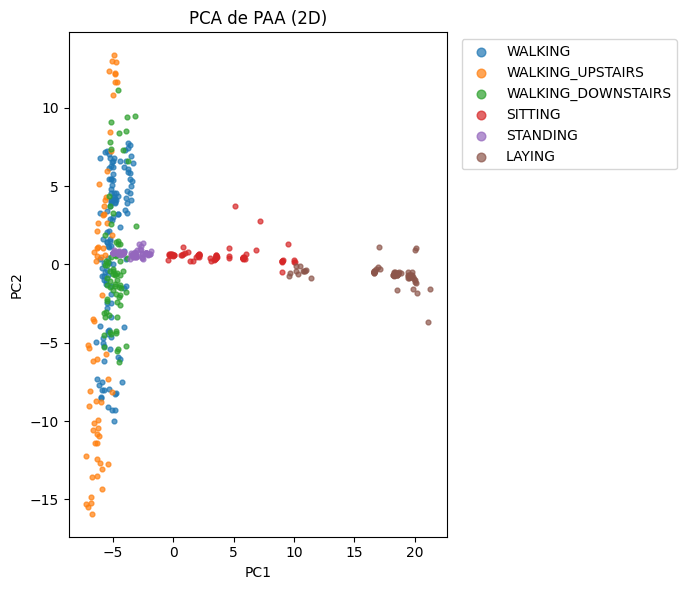

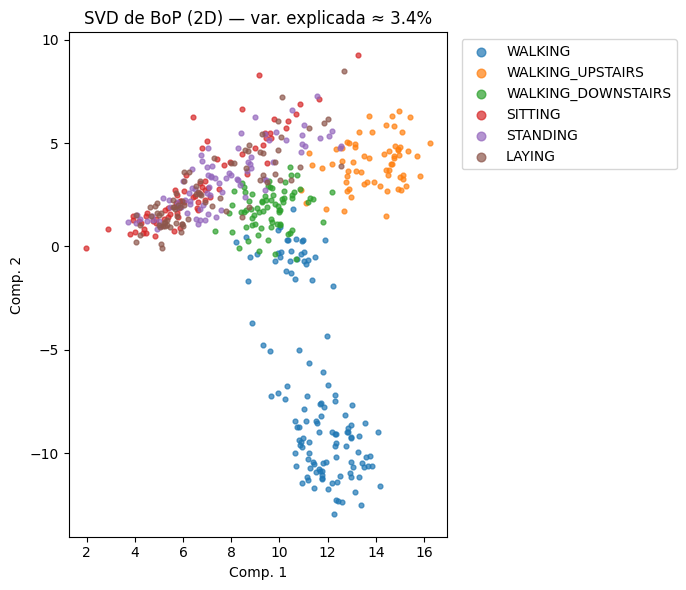

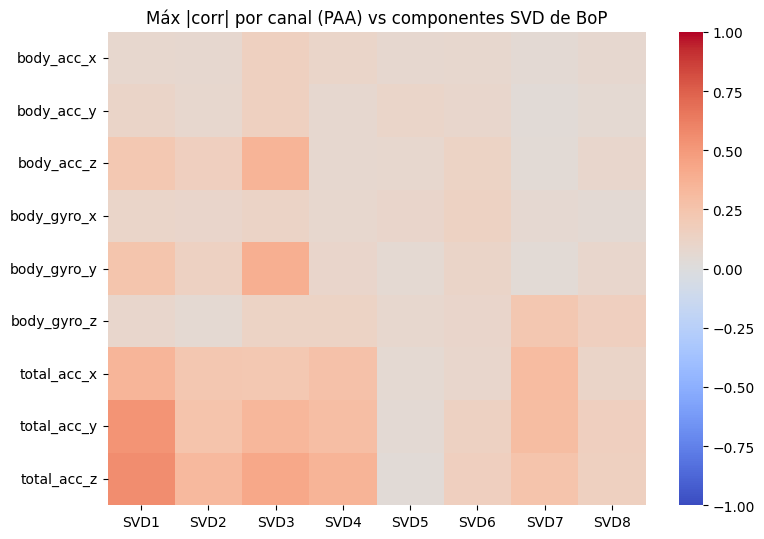

,SVD1,SVD2,SVD3,SVD4,SVD5,SVD6,SVD7,SVD8
body_acc_x,0.079,0.076,0.155,0.109,0.070,0.079,0.052,0.078
body_acc_y,0.110,0.084,0.156,0.078,0.103,0.093,0.038,0.058
body_acc_z,0.223,0.163,0.354,0.077,0.081,0.125,0.046,0.091
body_gyro_x,0.106,0.098,0.121,0.085,0.095,0.137,0.067,0.050
body_gyro_y,0.248,0.145,0.384,0.098,0.058,0.115,0.045,0.088
body_gyro_z,0.092,0.058,0.128,0.127,0.081,0.095,0.227,0.163
total_acc_x,0.345,0.231,0.225,0.273,0.061,0.090,0.310,0.112
total_acc_y,0.526,0.252,0.340,0.291,0.053,0.142,0.299,0.160
total_acc_z,0.560,0.325,0.423,0.356,0.032,0.163,0.258,0.151


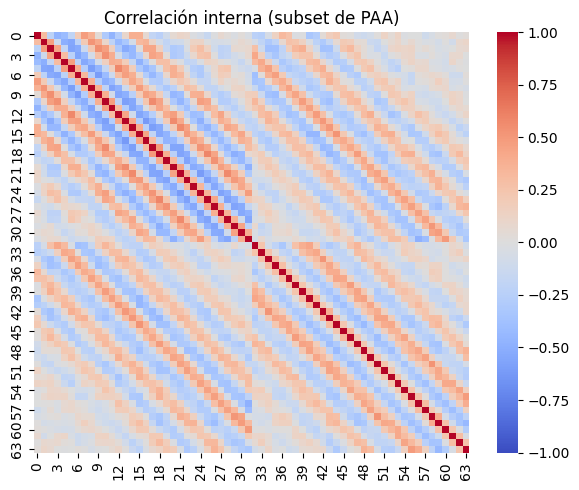

In [12]:
# ============================================
# Paso 5 — Validaciones rápidas (bloque único)
# Sanity checks + Separabilidad (PCA/SVD) + Correlaciones
# ============================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD

FIG_DIR = "../reports/figures"
os.makedirs(FIG_DIR, exist_ok=True)

# ------------------------
# 1) Sanity checks
# ------------------------
def sanity_dense(X, name):
    assert isinstance(X, np.ndarray), f"{name}: se esperaba np.ndarray"
    assert np.isfinite(X).all(), f"{name}: contiene NaN/Inf"
    var = X.var(axis=0)
    nz = (var > 0).sum()
    print(f"{name}: shape={X.shape} | var>0 cols = {nz}/{X.shape[1]} | "
          f"min_var={var.min():.3e}, max_var={var.max():.3e}")

def sanity_sparse(X, name):
    assert sparse.issparse(X), f"{name}: se esperaba sparse matrix"
    if X.nnz > 0:
        assert np.isfinite(X.data).all(), f"{name}: contiene NaN/Inf en data"
    density = X.nnz / (X.shape[0] * X.shape[1])
    nnz_per_col = np.asarray(X.getnnz(axis=0)).ravel()
    zero_cols = (nnz_per_col == 0).sum()
    print(f"{name}: shape={X.shape} | nnz={X.nnz} | density={density:.4%} | zero_cols={zero_cols}")

sanity_dense(X_PAA, "X_PAA (dense)")
sanity_sparse(X_BOP, "X_BOP (sparse)")
sanity_dense(X_IMG, "X_IMG (dense)")

# ------------------------
# 2) Separabilidad preliminar (PCA/SVD)
# ------------------------
# Intentar cargar nombres de actividad
id_to_name = None
try:
    act_df = pd.read_csv("../data/activity_labels.txt", sep=r"\s+", header=None, names=["id","activity"])
    id_to_name = dict(zip(act_df.id, act_df.activity))
except Exception:
    pass

def labels_to_names(y):
    if id_to_name is None:
        return pd.Series(y).map(lambda v: f"Class_{int(v)}")
    return pd.Series(y).map(lambda v: id_to_name.get(int(v), f"Class_{int(v)}"))

# --- PCA en PAA (2D)
X_paa_scaled = StandardScaler(with_mean=True, with_std=True).fit_transform(X_PAA)
Z_paa = PCA(n_components=2, random_state=42).fit_transform(X_paa_scaled)

plt.figure(figsize=(7,6))
for cls in np.unique(y_run):
    mask = (y_run == cls)
    plt.scatter(Z_paa[mask, 0], Z_paa[mask, 1], s=12, alpha=0.7, label=labels_to_names([cls])[0])
plt.title("PCA de PAA (2D)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(markerscale=1.8, bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "pca_paa_2d.png"), dpi=160, bbox_inches="tight")
plt.show()

# --- SVD (TruncatedSVD) en BoP (sparse) a 2D
svd_2 = TruncatedSVD(n_components=2, random_state=42)
Z_bop = svd_2.fit_transform(X_BOP)  # acepta sparse
expl_var = svd_2.explained_variance_ratio_.sum()

plt.figure(figsize=(7,6))
for cls in np.unique(y_run):
    mask = (y_run == cls)
    plt.scatter(Z_bop[mask, 0], Z_bop[mask, 1], s=12, alpha=0.7, label=labels_to_names([cls])[0])
plt.title(f"SVD de BoP (2D) — var. explicada ≈ {expl_var:.1%}")
plt.xlabel("Comp. 1"); plt.ylabel("Comp. 2")
plt.legend(markerscale=1.8, bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "svd_bop_2d.png"), dpi=160, bbox_inches="tight")
plt.show()

# ------------------------
# 3) Correlaciones PAA vs BoP (vía SVD de BoP)
# ------------------------
k = 8  # nº de componentes de BoP para comparar
svd_k = TruncatedSVD(n_components=k, random_state=42)
Z_bop_k = svd_k.fit_transform(X_BOP)  # (n_samples, k)

# Estandarización para correlación estable
X_paa_std = StandardScaler().fit_transform(X_PAA)     # (n, d_paa)
Z_bop_std = StandardScaler().fit_transform(Z_bop_k)   # (n, k)

# Correlación entre columnas: (d_paa + k) x (d_paa + k) -> extraemos bloque cruce
corr = np.corrcoef(X_paa_std.T, Z_bop_std.T)
d_paa = X_paa_std.shape[1]
corr_block = corr[:d_paa, d_paa:]  # d_paa x k

# Resumimos PAA por canal: max|corr| del bloque de segmentos de cada canal vs cada comp. SVD
segmentos = X_PAA.shape[1] // 9
canales = [
    "body_acc_x","body_acc_y","body_acc_z",
    "body_gyro_x","body_gyro_y","body_gyro_z",
    "total_acc_x","total_acc_y","total_acc_z"
]
agg = []
for i, ch in enumerate(canales):
    start = i * segmentos
    end   = (i + 1) * segmentos
    max_abs = np.abs(corr_block[start:end, :]).max(axis=0)
    agg.append(max_abs)

corr_df = pd.DataFrame(np.vstack(agg), index=canales, columns=[f"SVD{j+1}" for j in range(k)])

plt.figure(figsize=(8, 5.5))
sns.heatmap(corr_df, annot=False, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Máx |corr| por canal (PAA) vs componentes SVD de BoP")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "corr_paa_vs_bop_svd.png"), dpi=160, bbox_inches="tight")
plt.show()

display(corr_df.round(3))

# (Opcional) Correlación interna de PAA en un subset para figura legible
sub = X_PAA[:, :64]  # primeros 64 features
corr_interna = np.corrcoef(StandardScaler().fit_transform(sub), rowvar=False)

plt.figure(figsize=(6,5))
sns.heatmap(corr_interna, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Correlación interna (subset de PAA)")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "corr_interna_paa_subset.png"), dpi=160, bbox_inches="tight")
plt.show()

## 6. Exportación para el paper y trazabilidad

- Guardar **resumen de *features*** (`../reports/tables/pyts_feature_summary.csv`) con:  
  - `set_name`, `n_features`, `n_segments / window_size / word_size / n_bins`, canales usados, normalización y compute_time_sec (tiempo de cómputo en segundos que tomó generar cada conjunto de features).
- Guardar **figuras** de:  
  - PCA de `X_PAA` y de `X_BOP` (coloreado por actividad).  
- Guardar artefactos:  
  - `../artifacts/pyts_features_PAA.npz` (X_PAA, y, meta)  
  - `../artifacts/pyts_features_BOP.npz` (X_BOP, y, meta)  
  - `../artifacts/pyts_features_GAF_pooled.npz`


## 7. Limitaciones y plan para tsfresh

- **PyTS** resume forma global (PAA) y patrones locales discretizados (BoP), pero no agota todos los estadísticos temporales.  
- **tsfresh** complementará con **features estadísticas masivas** (autocorrelación, entropías, percentiles, coeficientes de Fourier), seguidas de **selección de *features***.  
- En el notebook 03 (modelado), compararemos desempeño usando:  
  - Solo PyTS (F1/F2)  
  - Solo tsfresh  
  - **Combinación PyTS + tsfresh** (si la dimensionalidad y el *overfitting* lo permiten)


## 8. Conclusiones (PyTS)

- Se definieron y justificaron **tres familias** de *features* en PyTS: **PAA (compacto)**, **BoP (motivos locales)** y **GAF/RP (opcional, firma visual)**.  
- Los parámetros propuestos priorizan **robustez, baja dimensionalidad e interpretabilidad**.  
- Dejaremos listas las matrices de *features* y el resumen para integrarlas en el **notebook de modelado** y en el **paper** (sección Metodología/Experimentación).
